#Project
Instructions:
- Please read the project description before your start.
- To download a copy of your ipython notebook: click ```File -> Download .ipyhon```
- Write your code in the code cells below each Step description. Write your answer to questions in a text cell. You may add extra cells if needed.

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

## Question 1: model and forecat electricity consumption data
Step 1: import data from Github
- Check to see that DataFrame elec has two columns ```date``` and ```elec```
- The variable ```elec``` is electricity retail sales to the residential sector in the US in million kilowatt hours.
- The sample is monthly and covers the period from 1973M1 to 2011M12 but use the sample up to **2010M12** (do not include observations from 2011)

In [5]:
elec = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/elec.csv')
elec.index = pd.date_range(start='1973-01-01', periods= elec.shape[0], freq='M')

# Define start and end date of sample
start = '1973-01-01'
end = '2011-01-01'

<ipython-input-5-3575ac376e8f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  elec.index = pd.date_range(start='1973-01-01', periods= elec.shape[0], freq='M')


Step 2: determine whether it is better to take the log of electricity consumption or not. Plot the level or the log of electricity consumption depending on your choice. Properly label the x- and y- axis in your plot

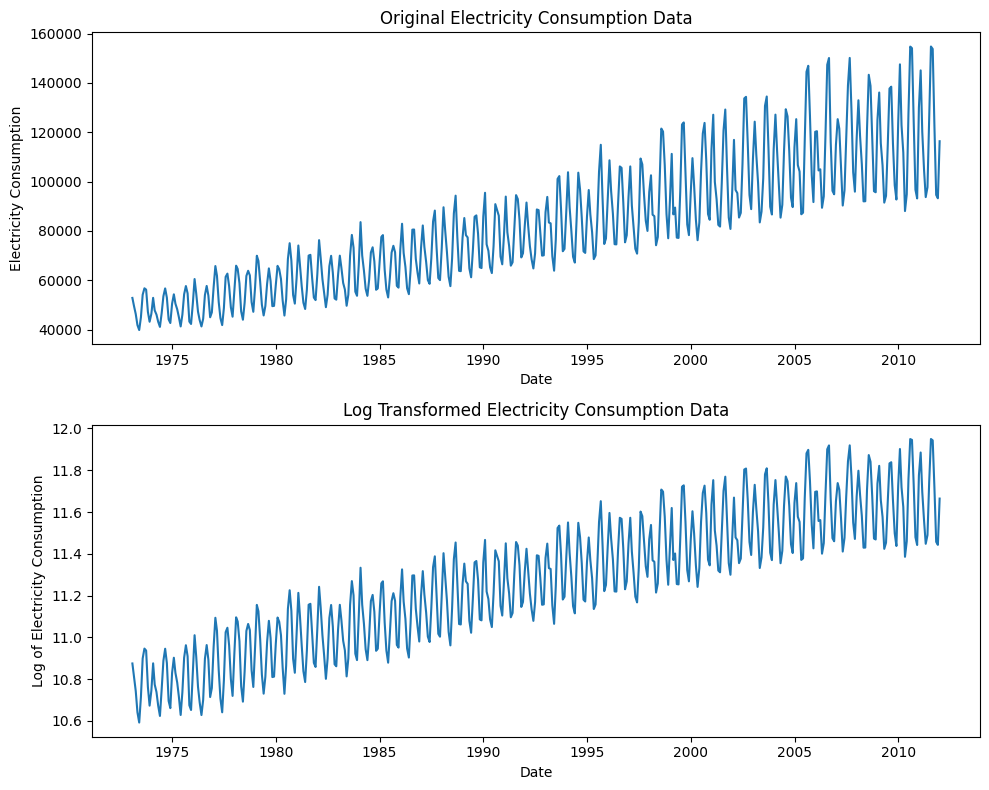

ADF Statistic: -0.212856
p-value: 0.936972
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570

ADF Statistic (Log): -1.276747
p-value (Log): 0.639742
Critical Values (Log):
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [19]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(elec['elec'])
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Electricity Consumption")
axes[0].set_title("Original Electricity Consumption Data")


axes[1].plot(np.log(elec['elec']))
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log of Electricity Consumption")
axes[1].set_title("Log Transformed Electricity Consumption Data")

plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import adfuller

result = adfuller(elec['elec'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(np.log(elec['elec']))
print('\nADF Statistic (Log): %f' % result[0])
print('p-value (Log): %f' % result[1])
print('Critical Values (Log):')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


Step 3: Estimate a model with a linear trend and a model with a quadratic trend. Which one would you choose?

In [20]:
elec['time'] = np.arange(len(elec))
elec['time_squared'] = elec['time']**2

elec_sub = elec[:'2010-12-01']

X_lin = sm.add_constant(elec_sub['time'])
lin_model = sm.OLS(np.log(elec_sub['elec']), X_lin).fit()
print(lin_model.summary())

X_quad = sm.add_constant(elec_sub[['time', 'time_squared']])
quad_model = sm.OLS(np.log(elec_sub['elec']), X_quad).fit()
print(quad_model.summary())

print(f"Linear Model AIC: {lin_model.aic}")
print(f"Linear Model BIC: {lin_model.bic}")
print(f"Quadratic Model AIC: {quad_model.aic}")
print(f"Quadratic Model BIC: {quad_model.bic}")

if quad_model.aic < lin_model.aic and quad_model.bic < lin_model.bic:
  print("Choose the Quadratic model")
else:
  print("Choose the Linear model")


                            OLS Regression Results                            
Dep. Variable:                   elec   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1649.
Date:                Sun, 04 May 2025   Prob (F-statistic):          4.63e-153
Time:                        22:42:12   Log-Likelihood:                 231.61
No. Observations:                 455   AIC:                            -459.2
Df Residuals:                     453   BIC:                            -451.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7779      0.014    789.909      0.0

Step 4: Depending on your choice of the model from Step 3, provide the plot and correlogram (up to 12 lags) of the residuals of the model you chose in Step 3.  Is there any seasonal pattern?

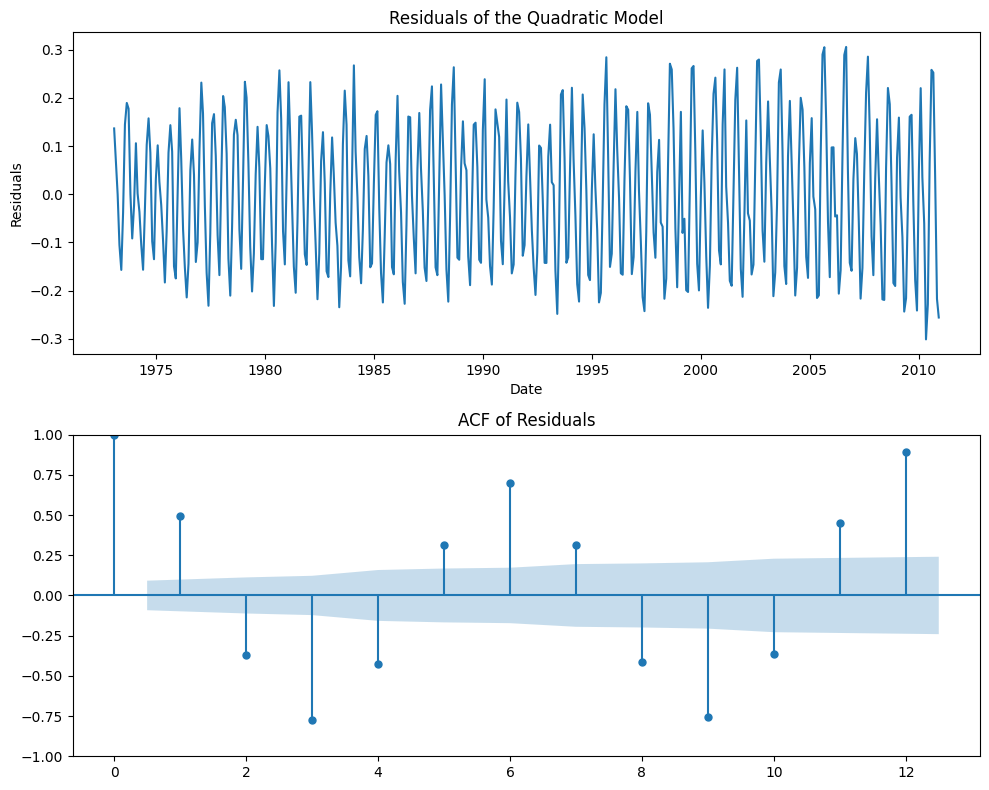

Yes, there is strong evidence of seasonality remaining in the residuals of the quadratic model.
The residual plot displays a clear cyclical pattern, and the ACF plot shows strong autocorrelation at lags 6 and 12.
This suggests the model did not fully capture the seasonal component, and a seasonal model (e.g., SARIMA) may be more appropriate.


In [21]:
residuals = quad_model.resid

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(residuals)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals of the Quadratic Model")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals, lags=12, ax=axes[1])
axes[1].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

print("Yes, there is strong evidence of seasonality remaining in the residuals of the quadratic model.")
print("The residual plot displays a clear cyclical pattern, and the ACF plot shows strong autocorrelation at lags 6 and 12.")
print("This suggests the model did not fully capture the seasonal component, and a seasonal model (e.g., SARIMA) may be more appropriate.")



Step 5: Estimate a model with a trend and a full set of dummy variables (for 12 months) and report the result.

In [37]:
elec_sub.index = pd.to_datetime(elec_sub.index)

elec_sub['time'] = np.arange(len(elec_sub))
elec_sub['time_squared'] = elec_sub['time'] ** 2

elec_sub['month'] = elec_sub.index.month
month_dummies = pd.get_dummies(elec_sub['month'], prefix='month', drop_first=True)

X = pd.concat([elec_sub[['time', 'time_squared']], month_dummies], axis=1)
X = sm.add_constant(X).astype(float)  # Ensure float type

y = np.log(elec_sub['elec']).astype(float)  # Ensure float type

X = X.loc[y.notna()]
y = y.loc[y.notna()]

model_dummy = sm.OLS(y, X).fit()
print(model_dummy.summary())


                            OLS Regression Results                            
Dep. Variable:                   elec   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1278.
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        22:55:14   Log-Likelihood:                 713.96
No. Observations:                 455   AIC:                            -1400.
Df Residuals:                     441   BIC:                            -1342.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.9137      0.011   1023.760   

Step 6: Provide  the  plot  and  correlogram  (up  to  12  lags)  of  the residuals  of  the  model  you estimated in Step 5. Is there any cycles or serial correlation in the residuals?

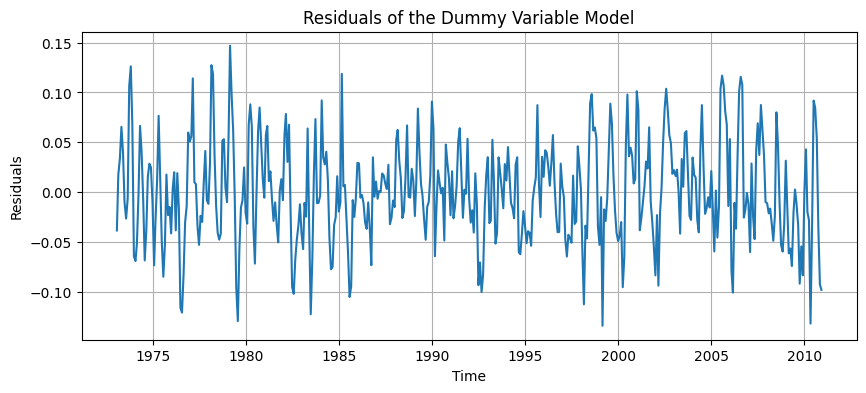

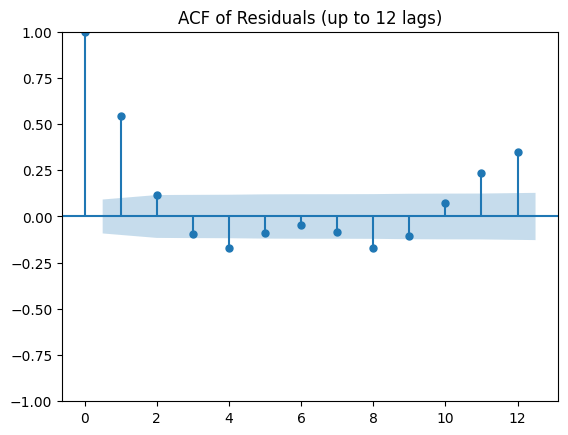

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

residuals = model_dummy.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of the Dummy Variable Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plot_acf(residuals, lags=12)
plt.title('ACF of Residuals (up to 12 lags)')
plt.show()



Step 7: Estimate an ARMA(p,q) model with $p= 0,1,2,3$ and $q= 0,1,2,3$ except $p=q=0$ and report SICs. Which lag orders would you choose?

In [44]:
import warnings
elec_log = np.log(elec['elec'])
elec_log = elec_log[:'2010-12-01']

results = []

for p in range(4):
    for q in range(4):
        if p == 0 and q == 0:
            continue  # Skip ARMA(0,0)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")  # Ignore convergence warnings
                model = ARIMA(elec_log, order=(p, 0, q))
                result = model.fit()
                sic = result.bic  # Schwarz Criterion
                results.append(((p, q), sic))
        except Exception as e:
            print(f"Failed for ARMA({p},{q}): {e}")

results.sort(key=lambda x: x[1])

for (p, q), sic in results:
    print(f"ARMA({p},{q}) : SIC = {sic:.2f}")

best_model = results[0]
print(f"\nBest ARMA model based on SIC: ARMA{best_model[0]} with SIC = {best_model[1]:.2f}")


ARMA(3,3) : SIC = -1108.30
ARMA(3,2) : SIC = -1007.42
ARMA(3,1) : SIC = -1003.36
ARMA(1,3) : SIC = -802.01
ARMA(3,0) : SIC = -801.20
ARMA(2,3) : SIC = -788.81
ARMA(2,2) : SIC = -746.95
ARMA(1,2) : SIC = -709.72
ARMA(2,1) : SIC = -657.63
ARMA(1,1) : SIC = -654.01
ARMA(0,3) : SIC = -601.71
ARMA(2,0) : SIC = -566.89
ARMA(0,2) : SIC = -516.86
ARMA(1,0) : SIC = -474.02
ARMA(0,1) : SIC = -235.86

Best ARMA model based on SIC: ARMA(3, 3) with SIC = -1108.30


Step 8: Provide the plot and correlogram (up to 12 lags) of the residuals of the model you chose in Step 7.  Is there any evidence of cycles in the residuals?

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


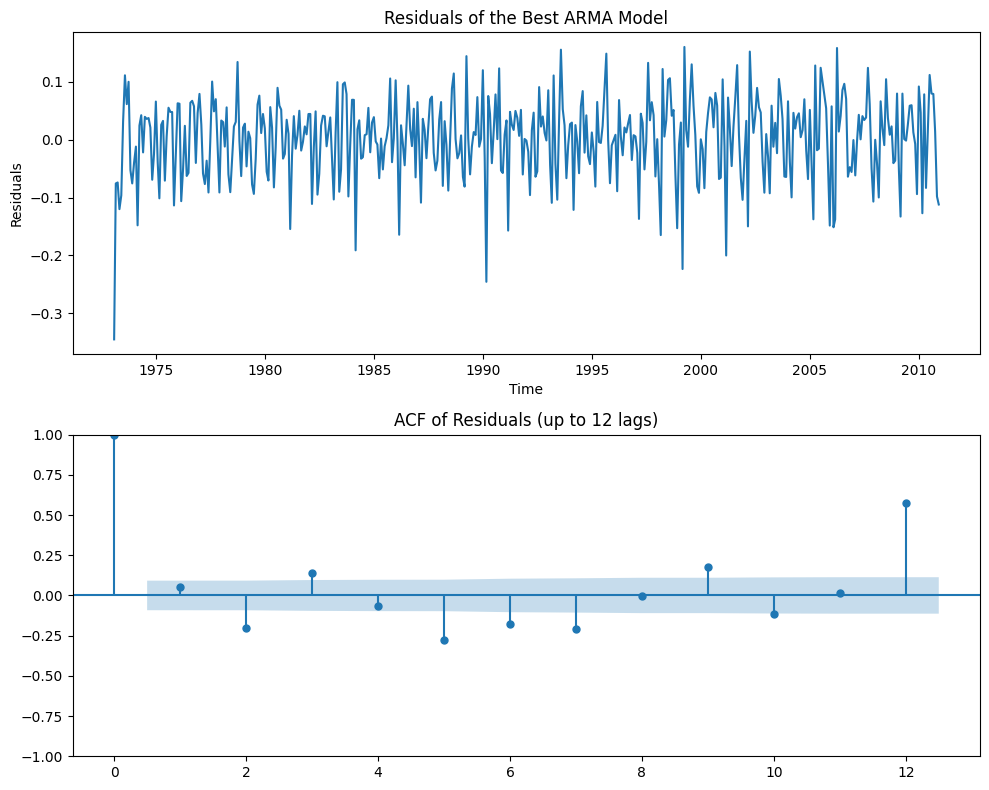

Analysis of Residual Plots:
The residual plot appears mostly random, indicating that the model captured much of the data's structure.
However, the ACF plot shows significant autocorrelation around lag 12.
This suggests there may still be some remaining seasonality or cycles not fully captured by the ARMA(3,3) model.
Consider using a SARIMA model if strong seasonal patterns are expected.


In [49]:
best_model = ARIMA(elec_log, order=(3, 0, 3)).fit()

residuals = best_model.resid

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(residuals)
axes[0].set_title("Residuals of the Best ARMA Model")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residuals")

plot_acf(residuals, lags=12, ax=axes[1])
axes[1].set_title("ACF of Residuals (up to 12 lags)")

plt.tight_layout()
plt.show()

print("Analysis of Residual Plots:")
print("The residual plot appears mostly random, indicating that the model captured much of the data's structure.")
print("However, the ACF plot shows significant autocorrelation around lag 12.")
print("This suggests there may still be some remaining seasonality or cycles not fully captured by the ARMA(3,3) model.")
print("Consider using a SARIMA model if strong seasonal patterns are expected.")

Step 9: Use  the  model  you  chose  in  Step 7,  forecast  the level  of  electricity  retail  sales  for year 2011 and compute its 95% interval forecasts as well. Plot your point and interval forecasts together with actual data for the period from 2008 to 2011.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


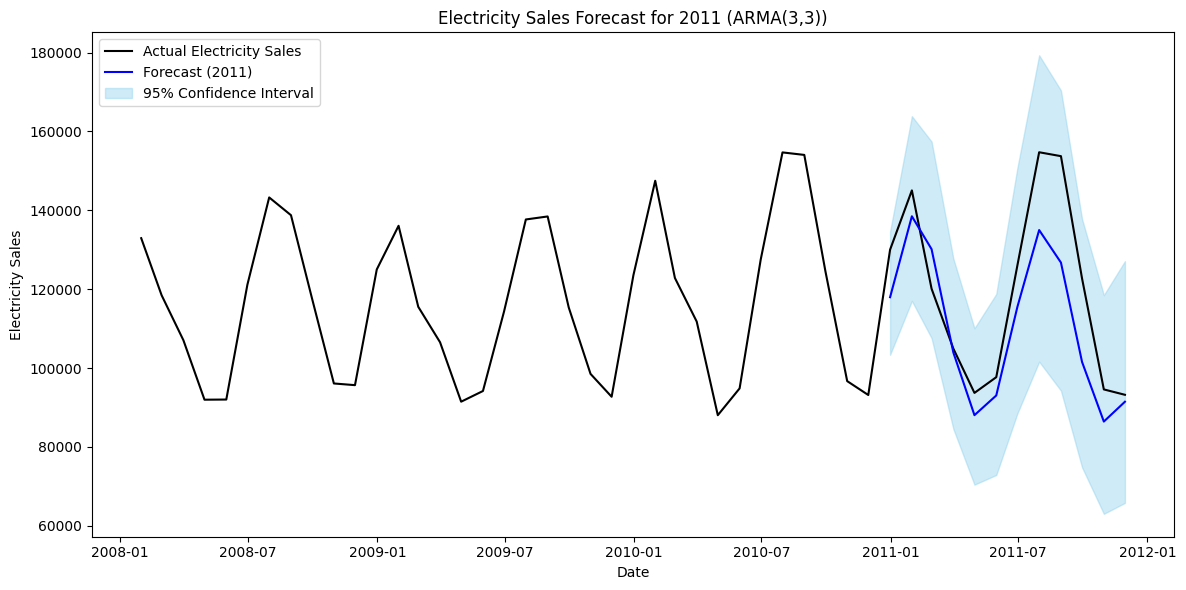

In [50]:
elec_log = np.log(elec['elec'])
elec_log_train = elec_log[:'2010-12-01']

model = ARIMA(elec_log_train, order=(3, 0, 3))
result = model.fit()

# Forecast for 12 months (2011)
forecast_result = result.get_forecast(steps=12)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)  # 95% interval

# Convert back from log to level
forecast_mean_exp = np.exp(forecast_mean)
forecast_ci_exp = np.exp(forecast_ci)

# Prepare actual data from 2008 to 2011
elec_actual = elec['elec']['2008-01-01':'2011-12-01']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(elec_actual, label='Actual Electricity Sales', color='black')
plt.plot(forecast_mean_exp, label='Forecast (2011)', color='blue')
plt.fill_between(forecast_ci_exp.index,
                 forecast_ci_exp.iloc[:, 0],
                 forecast_ci_exp.iloc[:, 1],
                 color='skyblue', alpha=0.4, label='95% Confidence Interval')

plt.title('Electricity Sales Forecast for 2011 (ARMA(3,3))')
plt.xlabel('Date')
plt.ylabel('Electricity Sales')
plt.legend()
plt.tight_layout()
plt.show()

#Question 2: model and forecat industrial production data
Step 1: import data from Github

- Check to see that DataFrame ```industrial``` has two columns ```date``` and ```lip```
- The variable ```lip``` is the log of the seasonally adjusted industrial production index of the US ($ip=100$ in 2007).
- The sample is monthly and covers the period from 1980M1 to 2014M12 but use the sample up to 2013M12 (do not include observations in 2014).

In [52]:
industrial = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/industrial.csv')
industrial.index = pd.date_range(start='1980-01-01', periods= industrial.shape[0], freq='ME')

# Define start and end date of sample
start = '1980-01-01'
end = '2014-01-01'

Step 2: Estimate a model with the intercept and a linear time trend and report the estimation result

In [53]:
industrial_sub = industrial[:'2013-12-01']
industrial_sub['time'] = np.arange(len(industrial_sub))

X = sm.add_constant(industrial_sub['time'])
y = industrial_sub['lip']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    lip   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     4419.
Date:                Sun, 04 May 2025   Prob (F-statistic):          5.52e-220
Time:                        23:09:26   Log-Likelihood:                 502.61
No. Observations:                 407   AIC:                            -1001.
Df Residuals:                     405   BIC:                            -993.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8960      0.007    558.048      0.0

<ipython-input-53-cf36473a0883>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industrial_sub['time'] = np.arange(len(industrial_sub))


Step 3: Compute the correlogram of the residuals in Step 2 up to 12 lags and describe any interesting characteristics. Would an AR model or an MA model fit the data better?

Step 4: Estimate an AR model, including the intercept and a linear time trend, with 1, 2, ..., 6 lags and report SICs of all these models.

Step 5: Choose the lag length for an AR model based on SIC and report the estimation result of the AR model with the chosen lag length.  Check out the ```Durbin-Watson``` statistic.  What doesthe DW statistic suggest?

Step 6: Now use the model chosen in Step 5. Consider the correlogram of the residuals up to 12 lags. Is there any evidence of serial correlation in the residuals?

Step 7: Use the model chosen in Step 5. Do the ```Breusch-Godfrey``` test (serial correlation LM test) on the residuals with 6 lags included.  Do you reject the null hypothesis at the 5% significance level?

Step 8: The Great Recession made industrial production drop substantially in 2008 and 2009. Do you think the model chosen in Step 5 became invalid to describe the dynamics ofthe industrial production after the Great Recession?  Try to provide some evidence for your conclusion using appropriate statistics.

Step 9: Forecast the **level** of the industrial production for year 2014 and compute its 95% interval forecasts as well. Plot your point and interval forecasts together with actual data forthe period from 2010 to 2014.



## Question 3: Modeling volatility using US Dollar / Australian Dollar exchange rate data
Step 1: import data from Github
- Check to see that DataFrame usdaud a column ```USDAUD```, which is the USD/AUD exchange rate
- The sample is daily and covers the period from Jan 2, 2001 to Oct 14, 2004

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

!pip install arch
from arch import arch_model

In [ ]:
usdaud = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/usdaud.csv')
usdaud.index = pd.date_range(start='2001-01-02', periods= usdaud.shape[0], freq='D')

Step 2: Compute and plot the first difference of the log(exchange rate), or $\Delta \log(usdaud_t) \times 100$. From now on, we will use $y_t$ to refer $\Delta \log(usdaud_t) \times 100$, which is the daily percentage change in USD/AUD exchange rate.

Hint: use ```np.log(var).diff()``` to compute the first difference of the log of ```var```.

Step 3: Plot the histogram and compute the descriptive statistics of $y_t$. Conduct the proper test to see if it is normally distributed.

Step 4: Compare the historgram of $y_t$ to a normal distribution.

Step 5: Compute the correlogram of squared $y_t$ up to 12 lags.

Step 6: Estimate an AR(1) model for squared $y_t$

Step 7: Estimate an ARCH(1) model and a GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

Step 8: Estimate an AR(1)-ARCH(1) model and an AR(1)-GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\rho y_{t-1} + \varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

Step 9: Plot the estimated conditional variance of the best-fitting model among the ones considered